In [1]:
# Cross-Lingual Word Embedding Alignment for English and Hindi
# Implementation of the Procrustes method

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Set random seed for reproducibility
np.random.seed(42)


In [2]:

# 1. Data Preparation

# 1.1 Download pre-trained FastText embeddings and MUSE dataset
def download_file(url, filename):
    """Download a file from URL if it doesn't exist"""
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists")

# Download English FastText embeddings
en_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec"
en_file = "wiki.en.vec"
download_file(en_url, en_file)

# Download Hindi FastText embeddings
hi_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.vec"
hi_file = "wiki.hi.vec"
download_file(hi_url, hi_file)

# Download MUSE bilingual lexicon (English-Hindi)
muse_url = "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt"
muse_file = "en-hi.txt"
download_file(muse_url, muse_file)

# 1.2 Load word embeddings (top 100,000 most frequent words)
def load_vectors(file_path, max_vocab=100000):
    """Load word vectors from file"""
    word_vectors = {}

    with open(file_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        n, d = map(int, f.readline().split())
        count = 0

        for line in tqdm(f, total=min(n, max_vocab), desc=f"Loading {file_path}"):
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            vector = np.array(tokens[1:], dtype=float)
            word_vectors[word] = vector
            count += 1

            if count >= max_vocab:
                break

    print(f"Loaded {len(word_vectors)} word vectors of dimension {d}")
    return word_vectors

# Load English word embeddings
en_vectors = load_vectors(en_file)

# Load Hindi word embeddings
hi_vectors = load_vectors(hi_file)

# 1.3 Load bilingual lexicon from MUSE dataset
def load_dictionary(file_path):
    """Load word translation pairs from dictionary file"""
    word_pairs = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            src, tgt = line.rstrip().split()
            word_pairs.append((src, tgt))

    print(f"Loaded {len(word_pairs)} word pairs")
    return word_pairs

muse_dict = load_dictionary(muse_file)

# 1.4 Split the dictionary into train and test sets
def split_dictionary(pairs, train_ratio=0.8):
    """Split dictionary into training and test sets"""
    np.random.shuffle(pairs)
    split_idx = int(len(pairs) * train_ratio)
    train_pairs = pairs[:split_idx]
    test_pairs = pairs[split_idx:]
    return train_pairs, test_pairs

train_dict, test_dict = split_dictionary(muse_dict)
print(f"Training dictionary: {len(train_dict)} pairs")
print(f"Test dictionary: {len(test_dict)} pairs")


Downloaded wiki.en.vec
Downloaded wiki.hi.vec
Downloaded en-hi.txt


Loading wiki.en.vec:   0%|          | 0/100000 [00:00<?, ?it/s]

Loaded 100000 word vectors of dimension 300


Loading wiki.hi.vec:   0%|          | 0/100000 [00:00<?, ?it/s]

Loaded 100000 word vectors of dimension 300
Loaded 38221 word pairs
Training dictionary: 30576 pairs
Test dictionary: 7645 pairs


In [3]:

# 2. Embedding Alignment using Procrustes Method

# 2.1 Prepare embedding matrices for alignment
def prepare_matrices(src_vectors, tgt_vectors, word_pairs):
    """Extract matrices of word vectors for the given word pairs"""
    # Filter pairs where both source and target words exist in embeddings
    valid_pairs = [(s, t) for s, t in word_pairs if s in src_vectors and t in tgt_vectors]

    if len(valid_pairs) == 0:
        raise ValueError("No valid translation pairs found in embeddings")

    # Create source and target matrices
    X = np.vstack([src_vectors[s] for s, _ in valid_pairs])
    Y = np.vstack([tgt_vectors[t] for _, t in valid_pairs])

    return X, Y, valid_pairs

# Prepare matrices for training
X_train, Y_train, valid_train_pairs = prepare_matrices(en_vectors, hi_vectors, train_dict)
print(f"Prepared training matrices with {len(valid_train_pairs)} word pairs")

# 2.2 Normalize embeddings to unit length
def normalize_embeddings(emb):
    """Normalize embeddings to unit length"""
    norms = np.sqrt(np.sum(emb**2, axis=1, keepdims=True))
    return emb / norms

X_train_norm = normalize_embeddings(X_train)
Y_train_norm = normalize_embeddings(Y_train)

# 2.3 Learn alignment matrix using Procrustes method
def procrustes_align(X, Y):
    """Learn orthogonal transformation from X to Y using Procrustes analysis"""
    # Compute X^T * Y
    XTY = X.T.dot(Y)

    # Apply SVD
    U, _, Vt = np.linalg.svd(XTY)

    # Compute orthogonal transformation matrix
    W = U.dot(Vt)

    return W

W = procrustes_align(X_train_norm, Y_train_norm)
print(f"Alignment matrix shape: {W.shape}")


Prepared training matrices with 22813 word pairs
Alignment matrix shape: (300, 300)


In [ ]:

# 3. Evaluation

# 3.1 Word translation function
def translate_word(word, src_vectors, tgt_vectors, W, k=5):
    """Translate a word using learned mapping W and return top-k translations"""
    if word not in src_vectors:
        return []

    # Get vector and apply transformation
    src_vec = src_vectors[word]
    src_vec_norm = src_vec / np.linalg.norm(src_vec)
    mapped_vec = src_vec_norm.dot(W)

    # Find nearest neighbors in target space
    similarities = []
    for tgt_word, tgt_vec in tgt_vectors.items():
        tgt_vec_norm = tgt_vec / np.linalg.norm(tgt_vec)
        sim = np.dot(mapped_vec, tgt_vec_norm)
        similarities.append((tgt_word, sim))

    # Sort by similarity and return top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]
# 3.2 Evaluate translation accuracy
def evaluate_word_translation(test_pairs, src_vectors, tgt_vectors, W):
    """Evaluate word translation accuracy using Precision@1 and Precision@5"""
    correct_1 = 0
    correct_5 = 0
    total = 0

    for src_word, tgt_word in tqdm(test_pairs, desc="Evaluating"):
        if src_word in src_vectors and tgt_word in tgt_vectors:
            translations = translate_word(src_word, src_vectors, tgt_vectors, W, k=5)

            if translations:
                total += 1

                # Check Precision@1 (exact match for top result)
                if translations[0][0] == tgt_word:
                    correct_1 += 1

                # Check Precision@5 (correct translation in top 5)
                if any(t[0] == tgt_word for t in translations):
                    correct_5 += 1

    p1 = correct_1 / total if total > 0 else 0
    p5 = correct_5 / total if total > 0 else 0

    return p1, p5

# Evaluate on test set
precision_1, precision_5 = evaluate_word_translation(test_dict, en_vectors, hi_vectors, W)
print(f"Precision@1: {precision_1:.4f}")
print(f"Precision@5: {precision_5:.4f}")

# 3.3 Analyze cosine similarities between aligned word pairs
def analyze_similarities(pairs, src_vectors, tgt_vectors, W):
    """Compute cosine similarities between aligned word pairs"""
    similarities = []

    for src_word, tgt_word in pairs:
        if src_word in src_vectors and tgt_word in tgt_vectors:
            # Get vectors
            src_vec = src_vectors[src_word]
            tgt_vec = tgt_vectors[tgt_word]

            # Normalize vectors
            src_vec_norm = src_vec / np.linalg.norm(src_vec)
            tgt_vec_norm = tgt_vec / np.linalg.norm(tgt_vec)

            # Apply transformation to source vector
            mapped_vec = src_vec_norm.dot(W)

            # Compute cosine similarity
            sim = np.dot(mapped_vec, tgt_vec_norm)

            similarities.append({
                'source': src_word,
                'target': tgt_word,
                'similarity': sim
            })

    return pd.DataFrame(similarities)

# Analyze similarities for a subset of word pairs
similarities_df = analyze_similarities(test_dict[:100], en_vectors, hi_vectors, W)
similarities_df.describe()


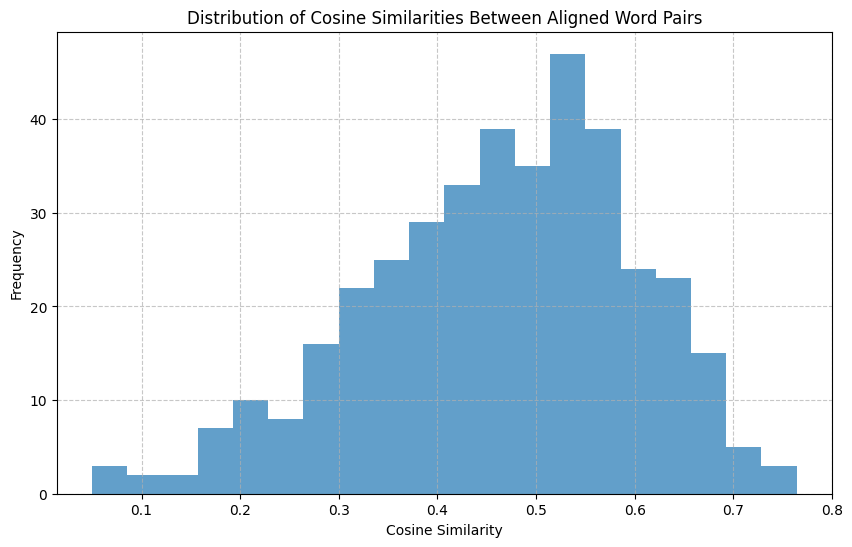


Evaluating with dictionary size: 5000
Procrustes alignment computed in 0.02 seconds


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-9-9c40a0d9cffd>:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mapped_vec = src_vec_norm.dot(W)



Evaluating with dictionary size: 10000
Procrustes alignment computed in 0.02 seconds


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]


Evaluating with dictionary size: 20000
Procrustes alignment computed in 0.03 seconds


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

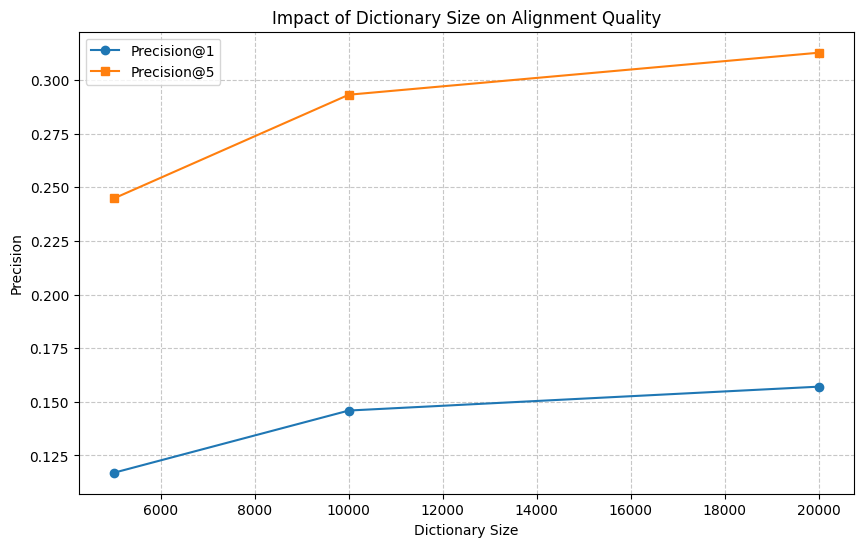

In [10]:

# Visualize similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities_df['similarity'], bins=20, alpha=0.7)
plt.title('Distribution of Cosine Similarities Between Aligned Word Pairs')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('similarity_distribution.png')
plt.show()

# 3.4 Ablation study: Impact of bilingual lexicon size
def ablation_study(dictionary, src_vectors, tgt_vectors, sizes=[5000, 10000, 20000]):
    """Evaluate the impact of dictionary size on alignment quality"""
    results = []

    for size in sizes:
        # Ensure we don't exceed dictionary size
        size = min(size, len(dictionary))

        print(f"\nEvaluating with dictionary size: {size}")

        # Use first 'size' pairs for training
        train_subset = dictionary[:size]
        # Use next 1000 pairs for testing
        test_subset = dictionary[size:size+1000]

        # Prepare matrices
        X, Y, _ = prepare_matrices(src_vectors, tgt_vectors, train_subset)

        # Normalize
        X_norm = normalize_embeddings(X)
        Y_norm = normalize_embeddings(Y)

        # Learn mapping
        W = procrustes_align(X_norm, Y_norm)

        # Evaluate
        p1, p5 = evaluate_word_translation(test_subset, src_vectors, tgt_vectors, W)

        results.append({
            'dictionary_size': size,
            'precision@1': p1,
            'precision@5': p5
        })

    return pd.DataFrame(results)

# Perform ablation study
ablation_results = ablation_study(muse_dict, en_vectors, hi_vectors, sizes=[5000, 10000, 20000])
ablation_results

# Visualize ablation study results
plt.figure(figsize=(10, 6))
plt.plot(ablation_results['dictionary_size'], ablation_results['precision@1'], 'o-', label='Precision@1')
plt.plot(ablation_results['dictionary_size'], ablation_results['precision@5'], 's-', label='Precision@5')
plt.title('Impact of Dictionary Size on Alignment Quality')
plt.xlabel('Dictionary Size')
plt.ylabel('Precision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig('ablation_results.png')
plt.show()

In [11]:

# 4. Example translations for common English words
example_words = ['computer', 'language', 'school', 'family', 'water', 'food', 'technology', 'health']

print("Example translations:")
for word in example_words:
    if word in en_vectors:
        translations = translate_word(word, en_vectors, hi_vectors, W, k=3)
        print(f"\n{word} -> {[t[0] for t in translations]}")
        print(f"Similarity scores: {[f'{t[1]:.4f}' for t in translations]}")


Example translations:


<ipython-input-9-9c40a0d9cffd>:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mapped_vec = src_vec_norm.dot(W)



computer -> ['कंप्यूटर', 'कम्प्यूटर', 'सिंप्यूटर']
Similarity scores: ['0.7496', '0.7225', '0.7093']

language -> ['भाषा', 'भाषाऔं', 'भाषाए']
Similarity scores: ['0.7308', '0.7085', '0.6969']

school -> ['स्कूल', 'स्कूल,', 'स्कूलो']
Similarity scores: ['0.7643', '0.7382', '0.7116']

family -> ['परिवार', 'सपरिवार', 'परिवारिक']
Similarity scores: ['0.5987', '0.5846', '0.5514']

water -> ['पानी', 'जल', 'जल।']
Similarity scores: ['0.7435', '0.6961', '0.6136']

food -> ['खाद्य', 'खाद्द', 'भोज्य']
Similarity scores: ['0.7127', '0.6529', '0.6418']

technology -> ['प्रौद्योगिकी', 'प्रौद्योगिकीय', 'जैवप्रौद्योगिकी']
Similarity scores: ['0.7456', '0.7144', '0.7142']

health -> ['स्वास्थ्य', 'स्वास्थ्यलाभ', 'स्वास्थ']
Similarity scores: ['0.7421', '0.6771', '0.6737']


In [12]:

# 5. Save alignment matrix and results
np.save('alignment_matrix.npy', W)
similarities_df.to_csv('word_pair_similarities.csv', index=False)
ablation_results.to_csv('ablation_study_results.csv', index=False)

print("\nImplementation complete. Results saved to files.")


Implementation complete. Results saved to files.
